In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from dataset_PA1.dataloader import Dataloader

In [30]:
class PyTorchNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(PyTorchNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size),
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
data_path = './dataset_PA1'
learning_rate = 0.01
epochs = 500
batch_size = 64
train_loader = Dataloader(path=data_path, is_train=True, batch_size=batch_size)
test_loader = Dataloader(path=data_path, is_train=False, batch_size=batch_size)


input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

In [ ]:
model_nn = PyTorchNN(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_nn.parameters(), lr=learning_rate)

train_losses = []
test_accuracies = []
test_losses = []

for epoch in range(epochs):
    model_nn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        images = torch.from_numpy(images).float().view(-1, 28*28)
        labels = torch.from_numpy(labels).float().argmax(dim=1)

        outputs = model_nn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(images)
    train_losses.append(epoch_loss)

    model_nn.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.from_numpy(images).float().view(-1, 28*28)
            labels = torch.from_numpy(labels).float().argmax(dim=1)

            outputs = model_nn(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = test_loss / len(images)
    test_losses.append(epoch_test_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

In [44]:
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def get_top3(pred, image, label, num_class=10):
    fig, axes = plt.subplots(3, num_class, figsize=(20, 6))
    plt.suptitle("Top 3 Predicted Images for Each Class (3-Layer NN)")
    
    for i in range(num_class):
        scores = pred[:, i]
        top3_i = np.argsort(scores)[::-1][:3]
        
        
        for j, img_idx in enumerate(top3_i):
            
            score = scores[img_idx]

            pred_class = i
            real_class = label[img_idx]
            
            ax = axes[j, i]
            
            image_reshaped = image[img_idx].reshape(28, 28)
            ax.imshow(image_reshaped, cmap='gray')
            ax.axis('off')

            ax.set_title(f"{score:.2f}", fontsize=8) 
            
            if j == 0:
                ax.set_xlabel(f"Pred {pred_class}\nTrue {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')
            else:
                ax.set_xlabel(f"True {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')

            if i == 0:
                 ax.set_ylabel(f"Rank {j+1}", rotation=0, labelpad=15, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


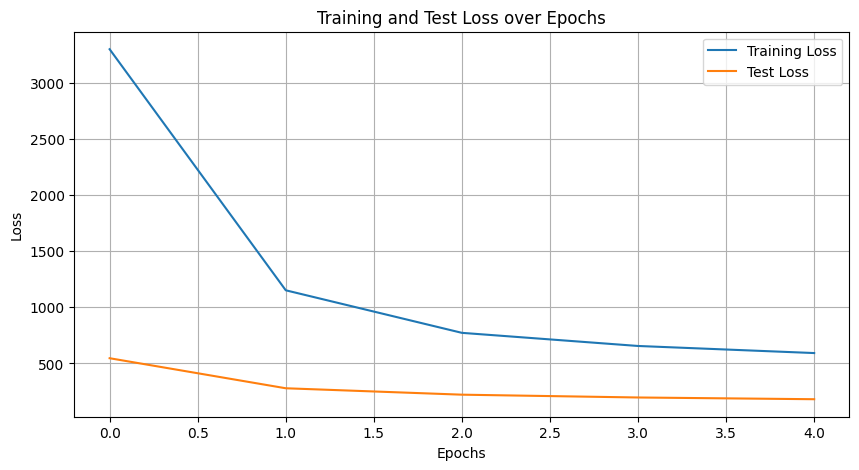

Confusion Matrix (sklearn):
[[ 958    0    3    1    0    7    6    1    4    0]
 [   0 1109    2    2    0    1    4    2   15    0]
 [  13    8  907    9   18    2   14   15   42    4]
 [   5    1   19  883    0   53    2   21   23    3]
 [   1    1    3    2  924    0   12    2    4   33]
 [  12    4    4   31   11  780   14    6   23    7]
 [  10    3    4    0   17   15  904    1    4    0]
 [   3    9   27    3    7    0    0  955    2   22]
 [   8    6    5   17   13   26   15   13  856   15]
 [  12    6    2    7   43   12    0   31    5  891]]
(10000,)

--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)


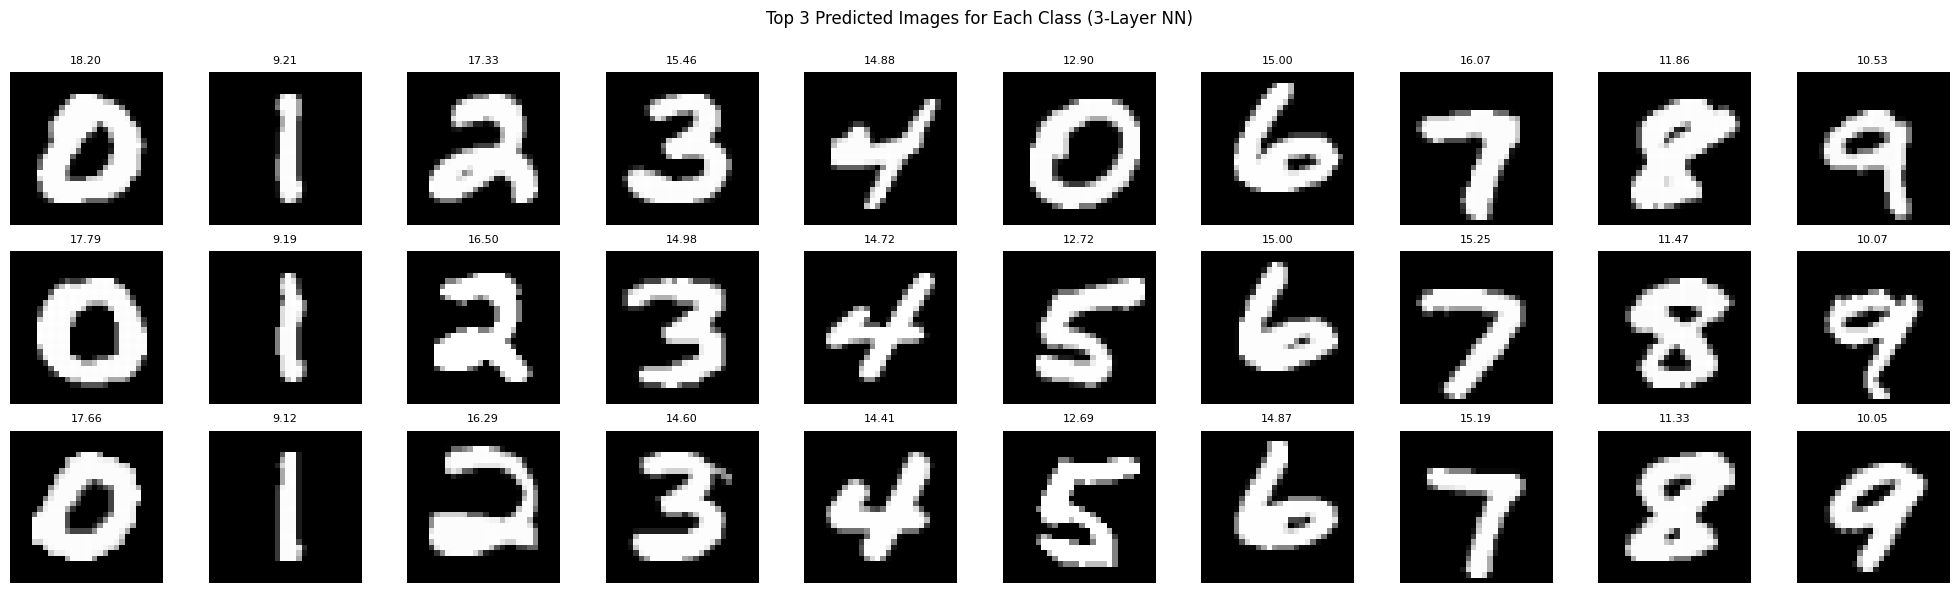

In [45]:
def predict_all(model, data_loader):
    model.eval()
    all_pred = []
    all_pred_score = []
    all_label = []
    
    with torch.no_grad():
        for image, label in data_loader:
            image_tensor = torch.from_numpy(image).float().view(-1, 28*28)
            outputs = model(image_tensor)

            _, predicted = torch.max(outputs.data, 1)
            all_pred.append(predicted)
            all_label.append(label)
            all_pred_score.append(outputs.data)
        final_pred = np.concatenate(all_pred, axis=0)
        final_label = np.concatenate(all_label, axis=0)
        final_pred_score = np.concatenate(all_pred_score, axis=0)
    return final_pred, final_label, final_pred_score

pred, gt, pred_score = predict_all(model_nn, test_loader)

plot_loss(train_losses, test_losses)

conf_matrix = sk_confusion_matrix(gt.argmax(axis=1), pred)
print("Confusion Matrix (sklearn):")
print(conf_matrix)

# Load test data again to show predictions
test_images = []
test_labels = []
for image, label in test_loader:
    test_images.extend(image)
    
    label = np.argmax(label, axis=1)
    test_labels.extend(label)
    

test_images = np.concatenate(test_images, axis=0)
test_labels = np.array(test_labels)
print(test_labels.shape)
print("\n--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)")
get_top3(pred_score, test_images, test_labels, num_class=10)